# Here I will simply build a classifier that detects the presence of a red ball or not in the training imagaes.
    - First build classifier
    - Then try to do the sliding window thing.
    - I think the purpose of sliding window is so we know the new location of the ball. E.g. If we find ball in top right then move in that direction.

In [1]:
# imports
import os
import numpy as np
from PIL import Image   # https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy import stats

In [2]:
# Define dirs
pos_img_dir = 'TrainingImages/positives/'
neg_img_dir = 'TrainingImages/negatives/'

# go through negatives
neg_images = []
neg_labels = np.zeros( len( os.listdir(neg_img_dir) ) )

print('Going through negative files:')
for filename in os.listdir(neg_img_dir):
    neg_images.append( np.array( Image.open( neg_img_dir + filename ).convert('L') )/255 )

print(np.shape(neg_images))

print('Going through positive files:')
# go through positives
pos_images = []
pos_labels = np.ones( len( os.listdir(pos_img_dir) ) )

for filename in os.listdir(pos_img_dir):
    pos_images.append( np.array( Image.open( pos_img_dir + filename ).convert('L') )/255 )

print(np.shape(pos_images))

Going through negative files:
(2600, 51, 51)
Going through positive files:
(308, 51, 51)


In [3]:
# Now weve got data in array form we can split into test and train data?
# With GREYSCALE images
# TODO Try with full colour images

X = np.concatenate((neg_images, pos_images))
y = np.concatenate((neg_labels, pos_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=300, shuffle=True)
#Prove test and train data is split correctly
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train[0].shape

(2326, 51, 51)
(2326,)
(582, 51, 51)
(582,)


(51, 51)

In [22]:
# Try flattening for sklearn to work
fX_train = np.reshape(X_train, (len(y_train),-1))
print(fX_train.shape)
fX_test = np.reshape(X_test, (len(y_test),-1))
print(fX_test.shape)

(2326, 2601)
(582, 2601)


In [100]:
####################################################################################
###### Super basic classifier predicts sphere if centre grey value is 0, no sphere otherwise
# would be good to compare my advanced machine kearning models with it
# Need to reduce false positives though

pos = np.reshape(pos_images, (308,-1)) # flatten
neg = np.reshape(neg_images, (2600,-1)) # flatten

def clf_dummy(f_image):
    # pos middle mean 0.3658575354475411 
    # neg middle mean 0.5311764705882352
    if (f_image[1163] == 0 ):
        return 1.
    else:
        return 0.

int(np.shape(test)[0]/2)
test[3,:1163]

#print( np.mean(pos[:300,:1163]), np.mean(neg[:300,1163]) )

print(np.shape(pos_images))
print(y_train)
#for i in range(300):
#    print(clf_dummy(pos[i]) )

correct=0
for i in range(fX_train.shape[0]):
    if (clf_dummy(fX_train[i]) == y_train[i]):
        correct=correct+1
print(correct / fX_train.shape[0] )

correct=0
fp=0
for i in range(fX_test.shape[0]):
    if (clf_dummy(fX_test[i]) == y_test[i]):
        correct=correct+1
    if(y_test[i]==0 and clf_dummy(fX_test[i])==1 ):
        fp = fp+1

print(correct / fX_test.shape[0] )
print(fp / fX_test.shape[0] )

(308, 51, 51)
[0. 0. 0. ... 0. 0. 0.]
0.8018056749785039
0.8058419243986255
0.08762886597938144


In [5]:
# Try a Random forrest classifier on image?
# Using fX, flattened 1D array for each image
# TODO still might have to change so I actually extract features
# TODO perhaps use a CNN with all colours first?

clf=RandomForestClassifier(n_estimators=50)
clf.fit(fX_train,y_train)
y_pred=clf.predict(fX_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9982817869415808


In [6]:
import PacMan_functionality as PacMan

# Initialise game
global_cloud, spheres_collected = PacMan.startup_scene()

# Create current camera position and angle
position = np.zeros([3])
angle = np.zeros([3])

# Obtain image and associated maps
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
type(depth)

numpy.ndarray

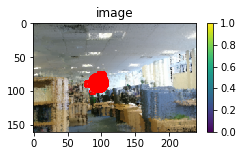

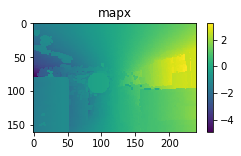

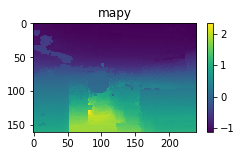

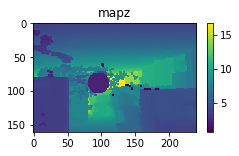

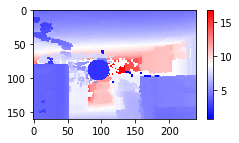

In [7]:
# Plot images using matplotlib.pyplot
plt.figure(figsize=(4,2))
plt.title('image')
plt.imshow(image)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.title('mapx')
plt.imshow(mapx)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.title('mapy')
plt.imshow(mapy)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.title('mapz')
plt.imshow(mapz)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(depth, cmap='bwr')
plt.colorbar()

(160, 240)


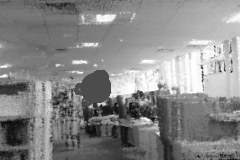

In [8]:
# Really stupid but here goes
# To convert the image into greyscale the same way I did when training the data I need to save the image as a png then reopen it
# TODO fix in the future if i can but cant atm
plt.imsave('image.png', image)
greyimg = Image.open('image.png').convert('L')
greyimgnp = np.asarray(greyimg)
print(greyimgnp.shape)
greyimg

(160, 240)
2.3450562704232105


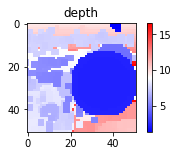

-0.2603576553033593


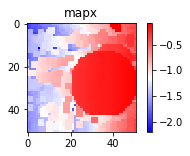

0.04575819465891324


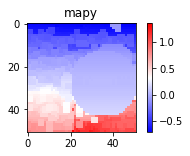

2.330109222847228


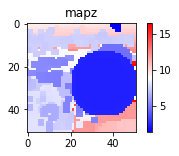

In [9]:
def sliding_window_classifier( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []

    for y in range(0, image_hight-window_size, step_size): 
        for x in range (0, image_width-window_size, step_size):
            test = image[y:y+window_size, x:x+window_size] # Had to remove last : because grey image has no colurs

            prediction = clf.predict(test.reshape(1,-1))

            if (prediction==1):
                print(i)
                print('X:{}, Y:{}'.format(x,y))
                print(prediction)
                plt.figure(figsize=(4,2))
                plt.imshow(test, cmap='gray', vmin=0, vmax=255)    
                plt.show()

                return (x,y)

    return -1,-1    # Return -1 as error

print(greyimgnp.shape)
#x,y = sliding_window_classifier(20, greyimgnp)
sliding_window_classifier(20, greyimgnp)

x=60
y=60

depthim = depth[x:x+51, y:y+51]
print(depth[x+25, y+25])

plt.figure(figsize=(4,2))
plt.title('depth')
plt.imshow(depth[x:x+51, y:y+51], cmap='bwr')
plt.colorbar()
plt.show()

print(mapx[x+25, y+25]) # Middle pixel should be sphere
plt.figure(figsize=(4,2))
plt.title('mapx')
plt.imshow(mapx[x:x+51, y:y+51], cmap='bwr')
plt.colorbar()
plt.show()

print(mapy[x+25, y+25]) # Middle pixel should be sphere
plt.figure(figsize=(4,2))
plt.title('mapy')
plt.imshow(mapy[x:x+51, y:y+51], cmap='bwr')
plt.colorbar()
plt.show()

print(mapz[x+25, y+25]) # Middle pixel should be sphere
plt.figure(figsize=(4,2))
plt.title('mapz')
plt.imshow(mapz[x:x+51, y:y+51], cmap='bwr')
plt.colorbar()
plt.show()

In [10]:
# Call classifier, if sphere found then calculate new coordinates. If x,y = -1,-1 then no sphere found and exit

In [11]:
# Move to new coordinates
# If i round then np.round(val, decimals=2) # spheres only specified to 2dp, doesnt make sence to use more

newx = mapx[x+25, y+25] #-0.2603576553033593
newy = mapy[x+25, y+25] #0.04575819465891324
newz = mapz[x+25, y+25] #2.330109222847228

newx = np.round(newx, decimals=2) #-0.26
newy = np.round(newy, decimals=2) #0.04
newz = np.round(newz, decimals=2) #2.33

position = np.asarray([0, 0, 0])
print('I am at position [{0}, {1}, {2}]'.format(*position))
print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

# Move position and update scene
position = np.asarray([newx, newy, newz])
print('I am now at position [{0}, {1}, {2}]'.format(*position))
global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

I am at position [0, 0, 0]
I have found 0 out of 11 spheres!

I am now at position [-0.26, 0.05, 2.33]
I have found 1 out of 11 spheres!



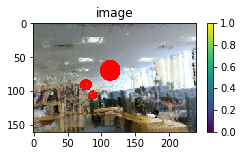

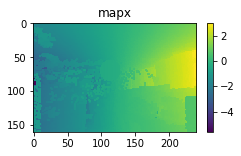

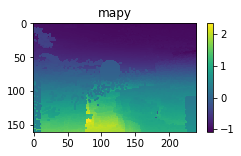

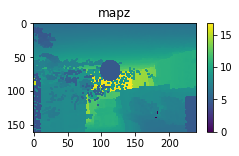

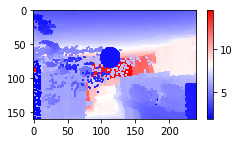

In [12]:
# get new images
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

# Plot images using matplotlib.pyplot
plt.figure(figsize=(4,2))
plt.title('image')
plt.imshow(image)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.title('mapx')
plt.imshow(mapx)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.title('mapy')
plt.imshow(mapy)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.title('mapz')
plt.imshow(mapz)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(depth, cmap='bwr')
plt.colorbar()

(160, 240)


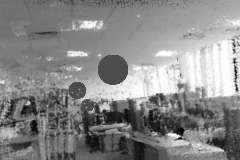

In [13]:
# Really stupid but here goes
# To convert the image into greyscale the same way I did when training the data I need to save the image as a png then reopen it
# TODO fix in the future if i can but cant atm
plt.imsave('image.png', image)
greyimg = Image.open('image.png').convert('L')
greyimgnp = np.asarray(greyimg)
print(greyimgnp.shape)
greyimg

In [14]:
sliding_window_classifier(5, greyimgnp)

(-1, -1)

In [15]:
# Move camera 2.3 forwards, towards sphere
import PacMan_functionality as PacMan
import numpy as np

# Initilise game
global_cloud, spheres_collected = PacMan.startup_scene()
position = np.asarray([0, 0, 0])
print('I am at position [{0}, {1}, {2}]'.format(*position))
print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

# Move position and update scene
#position = np.asarray([-0.18, 0.08, 2.31])
position = np.asarray([-0.18, 0.08, 2.3])    #mode[0,0] = 2.3
print('I am now at position [{0}, {1}, {2}]'.format(*position))
global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

I am at position [0, 0, 0]
I have found 0 out of 11 spheres!

I am now at position [-0.18, 0.08, 2.3]
I have found 1 out of 11 spheres!



imported functions


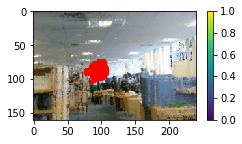

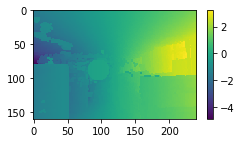

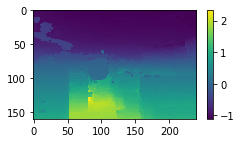

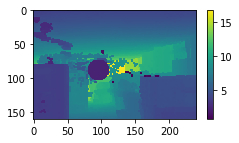

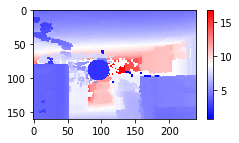

In [16]:
import PacMan_functionality as PacMan
print('imported functions')
# Initialise game
global_cloud, spheres_collected = PacMan.startup_scene()

# Create current camera position and angle
position = np.array([0,0,0])
angle = np.array([0,0,0])

# Obtain image and associated maps
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
type(depth)

## Plot images using matplotlib.pyplot
plt.figure(figsize=(4,2))
plt.imshow(image)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(mapx)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(mapy)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(mapz)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(depth, cmap='bwr')
plt.colorbar()

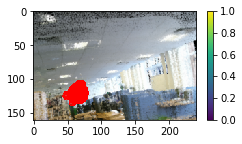

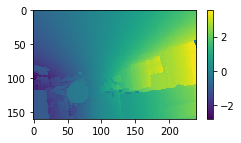

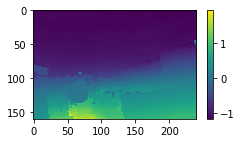

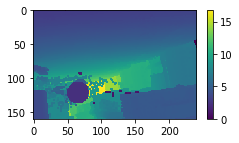

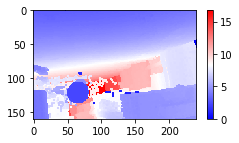

In [17]:
# Create current camera position and angle
position = np.array([0,0,0])
angle = np.array([0.1, 0.1, 0.1])

# Obtain image and associated maps
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
type(depth)

## Plot images using matplotlib.pyplot
plt.figure(figsize=(4,2))
plt.imshow(image)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(mapx)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(mapy)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(mapz)
plt.colorbar()

plt.figure(figsize=(4,2))
plt.imshow(depth, cmap='bwr')
plt.colorbar()

In [18]:
# Better sliding window
# Define function sliding window
# returns array of windows that I can classify at once
def sliding_window( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []

    for y in range(0, image_hight-window_size, step_size): 
        for x in range (0, image_width-window_size, step_size):
            windows.append(image[y:y+window_size, x:x+window_size]) # Had to remove last : because grey image has no colurs

    return np.array(windows) # Return windows as np array

res = sliding_window(20, greyimgnp)
np.shape(res)


(60, 51, 51)

In [19]:
#

In [20]:
#